<a href="https://colab.research.google.com/github/Yank224/Proyecto/blob/main/borrador_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica
### Reconocimiento de Rostros
Author: [Johan Rodríguez](https://github.com/Johanx22x)

Note: When using this notebook, you must select a GPU Hardware Accelerator instead of CPU. Go to Runtime->Change Runtime Type and select any option that uses GPU.

# Dependencies

In [3]:
!pip install face_recognition         # Install face_recognition package using pip
import face_recognition
import cv2                            # Import OpenCV
import numpy as np
from matplotlib import pyplot as plt  # pyplot
from datetime import datetime

# ipywidgets packages
import ipywidgets as widgets
from IPython.display import display, clear_output

# Live Streaming dependencies
from IPython.display import Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

# Utils

## In-memory data

In [8]:
registered_faces = {}
registered_professor = []
registered_estudent = []
registered_misceláneao = []
registered_aula = []
registered_curso = []


"""
{
  nombre_curso: Intro,
  profesores: [ id1 ],
  estudiantes: [ id1, id2, id3, id4 ]
}

def buscar_num_en_lista(num, lista):
  for n in lista:
    if num == n:
      return True
  return False

cuantos profes en el curso?
(similar a los correos electronicos)

cuantos estudiantes?
(similar a los correos electronicos)
--> Validar que no se agreue el mismo estudiantes dos veces
----->

"""


'\n{\n  nombre_curso: Intro,\n  profesores: [ id1 ],\n  estudiantes: [ id1, id2, id3, id4 ]\n}\n\ndef buscar_num_en_lista(num, lista):\n  for n in lista:\n    if num == n:\n      return True\n  return False\n\ncuantos profes en el curso?\n(similar a los correos electronicos)\n\ncuantos estudiantes?\n(similar a los correos electronicos)\n--> Validar que no se agreue el mismo estudiantes dos veces\n----->\n\n'

## face recognition

In [9]:
def check_if_face_registered(face_encoding):
  for _, registered_face in registered_faces.items():
    if True in face_recognition.compare_faces([face_encoding], registered_face):
      return True
  return False

## Real time streaming

In [10]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 800, 600);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 800; //video.videoWidth;
      captureCanvas.height = 600; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [11]:
# JavaScript code to stop the webcam stream
js_stop_stream = """
    const stream = video.srcObject;
    const tracks = stream.getTracks();

    tracks.forEach(function(track) {
        track.stop();
    });

    video.srcObject = null;
    div.style.display = 'none';  // Hide the container
"""

# Function to stop the video streaming
def stop_video_stream():
    display(Javascript(js_stop_stream))

# Register Faces

In [12]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
print(registered_faces)

{'Torres': array([-0.17791003,  0.09413037,  0.00819212, -0.05148554, -0.05548401,
       -0.10124871,  0.02367999, -0.15630302,  0.22841866, -0.14013427,
        0.24311233, -0.02084132, -0.20147964, -0.05777613, -0.0442603 ,
        0.06280056, -0.1534481 , -0.09838848, -0.03288668, -0.0635656 ,
        0.11028151, -0.02027438,  0.02785061,  0.05941194, -0.11088268,
       -0.29014364, -0.14304125, -0.09006777,  0.01500731, -0.06427954,
        0.04825096,  0.01510908, -0.20246689, -0.09479128, -0.05038475,
        0.06042609, -0.03368488,  0.00520577,  0.18205358, -0.08058068,
       -0.13855091, -0.0561323 , -0.00198445,  0.22137547,  0.13747621,
        0.04965843, -0.01107501, -0.15448967,  0.12829441, -0.18875027,
        0.0252877 ,  0.11457785,  0.07215089,  0.01803528,  0.09726651,
       -0.10195156,  0.04968107,  0.15068176, -0.2087093 ,  0.0224463 ,
        0.03180641, -0.07497741, -0.01389706, -0.02405761,  0.20650384,
        0.05247265, -0.09717795, -0.08276716,  0.1742

In [ ]:
print(registered_name)

tony


# Registered_Person

In [14]:

def agregar_persona(type):
    print("informacion adicional de: ", registered_name)
    cedula = input("Ingrese el id: ")
    nombre = registered_name
    fecha= input("Ingrese su fecha de nacimiento(D/M/A): ")
    nacionalidad= input("Ingrese su nacionalidad ")
    telefono= input("Ingrese su numero de telefono de casa: ")
    celular=input("Ingrese su numero de celular: ")
    telefonos={"casa": telefono,        #diccionario para agregar los dos numeros de telefono
                "celular": celular
              }
    cant = int(input("cuantos correos electronicos desea agregar? ")) #Para crear listas con correos dependiendo de cuantos el usuario quiere ingresar
    imails = []
    while cant >0:
      imail = input("Ingrese su dirección de correo electronico: ")
      imails.append(imail)
      cant-=1
    direccion= input("Ingrese su dirección: ")

    if type == "profesor":
      especialidad= input("Ingrese su especialidad: ")
      estado= input("Ingrese su estado civil: ")   #adicional
      asignatura = input("Ingrese la asignatura que enseña: ") #adicional
      imagen=registered_faces

      # Crear un diccionario con la información del profesor
      profesor = {
          "Identificacion": cedula,
          "nombre": nombre,
          "Fecha de nacimiento": fecha,
          "Nacionalidad": nacionalidad,
          "Números de teléfono y celular": telefonos,
          "imail ": imails,
          "Dirección": direccion,
          "Especialidad": especialidad,
          "Estado civil": estado,
          "Asignatura que enseña": asignatura,
          "imagen del profesor": imagen
          }
      registered_professor.append(profesor)
      print("Profesor agregado exitosamente.")
    elif type == "estudiante":
      carrera= input("Ingrese su carrera: ")
      genero= input("Ingrese su genero: ")   #adicional
      estatura= input("Ingrese su estatura: ") #adicional
      imagen=registered_faces
      estudiante = {
            "Identificacion": cedula,
            "nombre": nombre,
            "Fecha de nacimiento": fecha,
            "Nacionalidad": nacionalidad,
            "Números de teléfono y celular": telefonos,
            "Dirección": direccion,
            "carrera": carrera,
            "Genero": genero,
            "Estatura del estudiante": estatura,
            "imagen del estudiante": imagen
            }
      registered_estudent.append(estudiante)
      print("Estudiante agregado exitosamente.")

    elif type == 'micelaneo':
      turno= input("Ingrese el turno en el que trabaja: ")
      genero= input("Ingrese su genero: ")   #adicional
      estatura= input("Ingrese su estatura: ") #adicional
      imagen=registered_faces

      # Crear un diccionario con la información del miscelaneo
      miselaneo = {
          "Identificacion": cedula,
          "nombre": nombre,
          "Fecha de nacimiento": fecha,
          "Nacionalidad": nacionalidad,
          "Números de teléfono y celular": telefonos,
          "Dirección": direccion,
          "Turno": turno,
          "Genero": genero,
          "Estatura del miscelaneo": estatura,
          "imagen del miscelaneo": imagen
          }
      registered_misceláneao.append(miselaneo)
      print("miscelaneo agregado exitosamente.")


# Buscar Prof y estudiantes

In [15]:
def buscar_profesor(registered_professor, name):
    for i in registered_professor:
        if i["nombre"] == name:
            return i
    return None

def buscar_estudiante(registered_estudent, name):
    for estudiante in registered_estudent:
        if estudiante["nombre"] == name:
            return estudiante
    return None


# Registrar Aula y curso

In [16]:
def agregar_aula():
    print("informacion adicional del aula")
    numero_de_aula = input("Ingrese el número de aula: ")
    miselaneo = input(" ingrese el miselaneoa que le corresponde este aula: ")


    # Crear un diccionario con la información del miscelaneo
    aula = {
        "número de aula": numero_de_aula,
        "miselaneo": miselaneo,
        }
    registered_aula.append(aula)
    print("aula agregada exitosamente.")
    print(registered_aula)

def agregar_curso():
    print(" --- Crear curso ---")
    lista_estudiantes = []
    lista_profesores = []
    codigo = int(input("Ingrese el codigo del curso: "))
    nombre = input("ingrese el nombre del curso: ")
    periodo = int(input(" ingrese el periodo: "))
    carrera = input("a que carrera pertenece el curso: ")
    prof = int(input("Digite cuantos profesores hay en el curso:  "))
    for i in range(1, opcion-2):
        while True:
            nombre_profesor = input("Ingrese el nombre del profesor #" + str(i) + " que está en el curso: ")
            profesor = buscar_profesor(registered_professor, nombre_profesor)
            if profesor is not None:
                lista_profesores.append(profesor)
                break
            else:
                print("Ese profesor no está registrado. Por favor, inténtelo nuevamente.")


    opcion1 = int(input("Digite cuantos estudiantes hay en el curso:  "))
    for i in range(1, opcion1-2):
        while True:
            nombre_estudiante = input("Ingrese el nombre del estudiante #" + str(i) + " que está en el curso: ")
            estudiante = buscar_estudiante(registered_estudent, nombre_estudiante)
            if estudiante is not None:
                lista_estudiantes.append(estudiante)
                break
            else:
                print("Ese estudiante no está registrado. Por favor, inténtelo nuevamente.")

    horario = input("ingrese el horario de lecciones: ")
    aula = input(" ingrese el aula donde se imparte: ")
    curso = {
        "codigo": codigo,
        "nombre": nombre,
        "periodo": periodo,
        "carrera" : carrera,
        "estudiantes": lista_estudiantes,
        "profesores" : profesor,
        "horario" : horario,
        "aula": aula
        }
    registered_curso.append(curso)
    print("curso agregado exitosamente.")
    print(registered_curso)



# Menús

In [ ]:
def consultas():
  print("Bienvenido al menú de consultas: ")
  cont = 10
  while cont > 0:
    print(" 1. lista de profesores: ")
    print(" 2. lista de estudiantes: ")
    print(" 3. lista de miscelaneos: ")
    print(" 4. lista de aulas: ")
    print(" 5. lista de cursos: ")
    print(" 6. Reporte de asistencia: ")
    print(" 7. Estudiantes matriculados(forma ascendente por edad).  ") # ordenamiento burbuja
    print(" 8. Estudiantes matriculados(forma descendente por edad). ") # ordenamiento por inserción
    print(" 9. Record de estudiante que más veces asistió a un curso: ")
    print(" 10. Record de estudiante que más veces asistió a un curso: ")
    print(" 11. Hora de más personas reportadas en un curso ") #indicar la cantidad de personas (mostrar la información de cada persona) y mostrar una imagen con un cuadro con el nombre de cada persona.
    print(" 12. Profesor con más cursos a cargo. ") # presentar una lista con todos los cursos que imparte(elegida por los autores)
    print("13. Salir de consultas. ")

    op = int(input(" Seleccione una opción: "))
    if op ==1:
      print(registered_professor)
    elif op == 2:
      print(registered_estudent)
    elif op == 3:
      print(registered_misceláneao)
    elif op == 4:
      print(registered_aula)
    elif op == 5:
      print(registered_curso)
    elif op == 6:
      print("hacer consulta 8")
      #Reporte de asistencia Se debe mostrar la información de cada persona que fue reportada en una asistencia (la información de esa persona se debe obtener de la lista de profesores, estudiantes y/o misceláneo o miscelánea), la fecha y hora. Además, mostrar la imagen con un cuadro con el nombre de la persona. También hay que mostrar la fecha y hora del reporte de la asistencia.
    elif op == 7:
      print("hacer consulta 7")
    elif op == 8:
      print("hacer consulta 8")
    elif op == 9:
      print("hacer consulta 9 ")
    elif op == 10:
      print("hacer consulta 10 ")
    elif op == 11:
      print("hacer consulta 11 ")
    elif op == 12:
      print("hacer consulta 12 (inventada)")
    elif op == 13:
      print("saliendo de consultas.....")
      break
    else:
        print("Opción no válida. Por favor, selecciona una opción válida.")

cont = 10
while cont > 0:
    print("     Menú:     ")
    print(" Ingrese donde quiere agregar a la persona registada anteriormente: ")
    print("1. Profesor(a)")
    print("2. Estudiante")
    print("3. Miscelaneo/a")
    print("4. aula")
    print("5. curso")
    print("6. Consultas")
    print("7. Salir")

    opcion = int(input("Selecciona una opción: "))

    if opcion ==1:
      agregar_persona("profesor")
    elif opcion == 2:
      agregar_persona("estudiante")
    elif opcion == 3:
      agregar_persona("micelaneo")
    elif opcion == 4:
      agregar_aula()
    elif opcion == 5:
      agregar_curso()
    elif opcion == 6:
      consultas()
    elif opcion == 7:
      print("saliendo del programa ....")
      registered_faces = {}
      break
    else:
        print("Opción no válida. Por favor, selecciona una opción válida.")

     Menú:     
 Ingrese donde quiere agregar a la persona registada anteriormente: 
1. Profesor(a)
2. Estudiante
3. Miscelaneo/a
4. aula
5. curso
6. Consultas
7. Salir
Selecciona una opción: 6
Bienvenido al menú de consultas: 
 1. lista de profesores: 
 2. lista de estudiantes: 
 3. lista de miscelaneos: 
 4. lista de aulas: 
 5. lista de cursos: 
 6. Reporte de asistencia: 
 7. Estudiantes matriculados(forma ascendente por edad).  
 8. Estudiantes matriculados(forma descendente por edad). 
 9. Record de estudiante que más veces asistió a un curso: 
 10. Record de estudiante que más veces asistió a un curso: 
 11. Hora de más personas reportadas en un curso 
 12. Profesor con más cursos a cargo. 
13. Salir de consultas. 
 Seleccione una opción: 1
[{'Identificacion': '123', 'nombre': 'yank', 'Fecha de nacimiento': '2312', 'Nacionalidad': 'cr', 'Números de teléfono y celular': {'casa': '567', 'celular': '45'}, 'imail ': ['yante04@estuiantec.cr'], 'Dirección': 'er', 'Especialidad': 'tgh'

# Recognize Faces

<IPython.core.display.Javascript object>

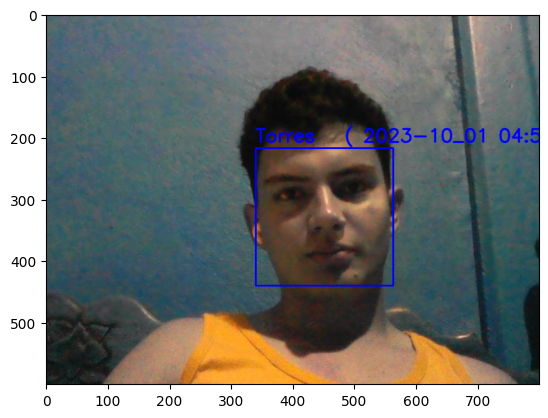

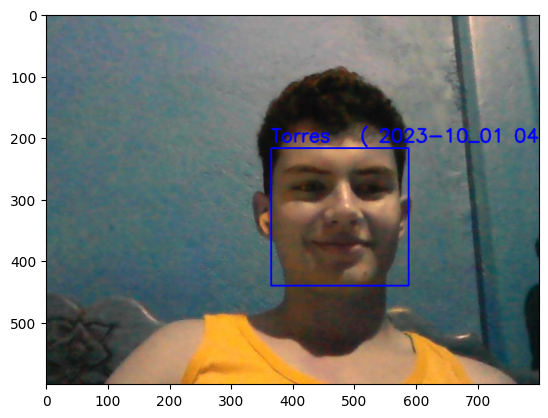

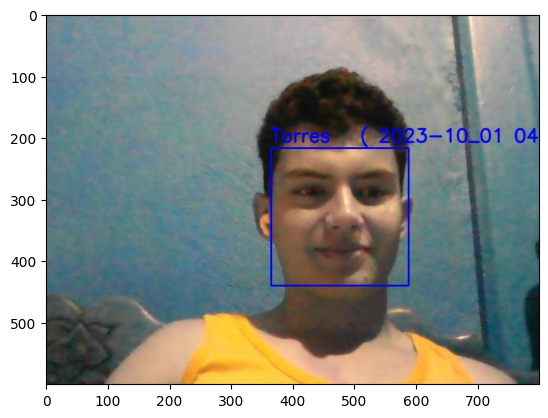

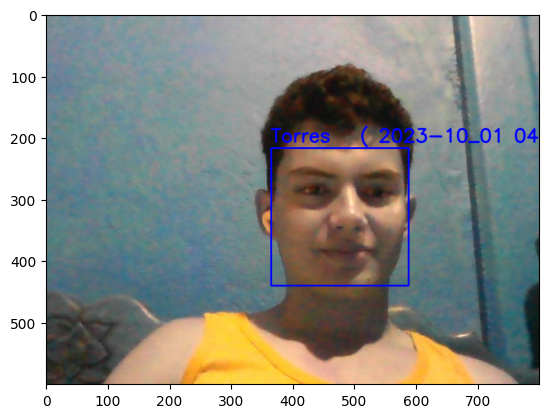

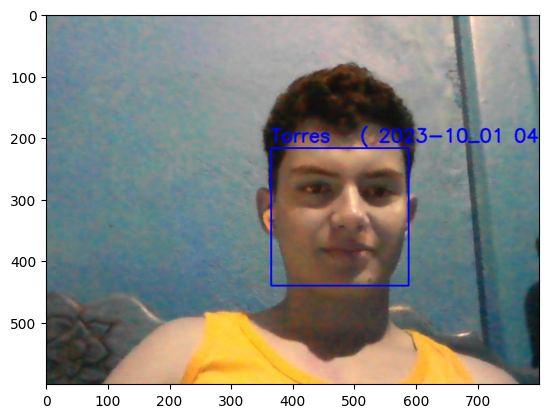

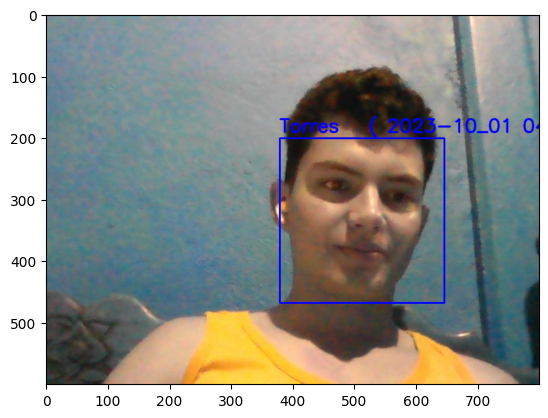

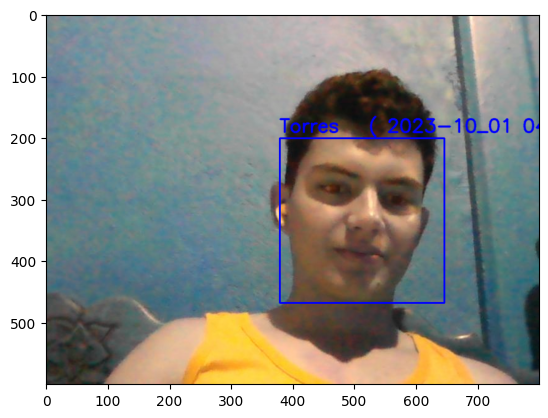

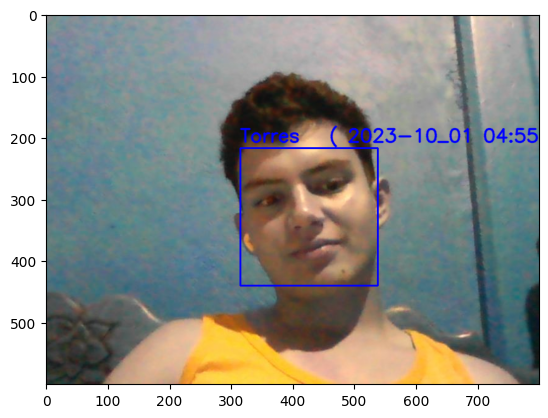

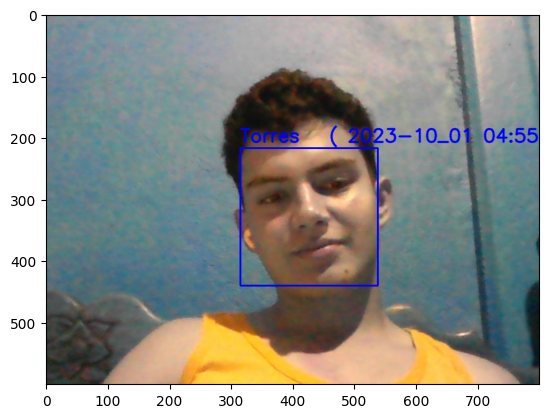

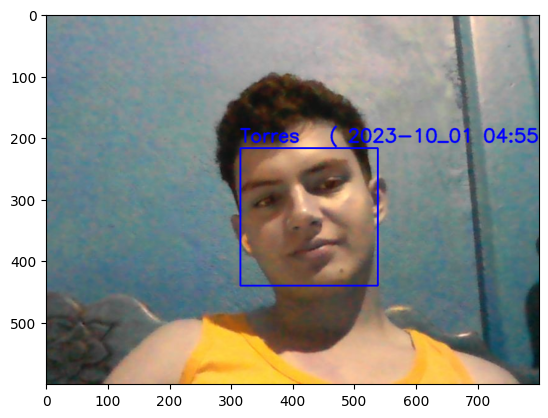

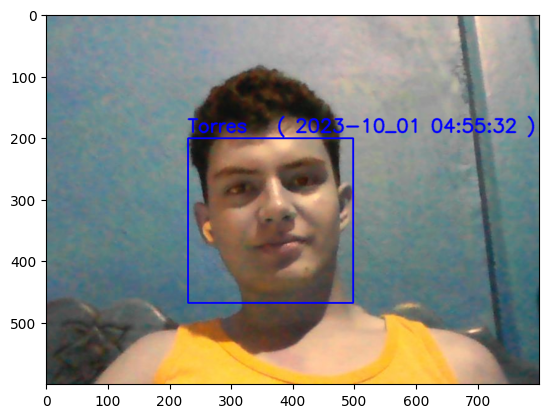

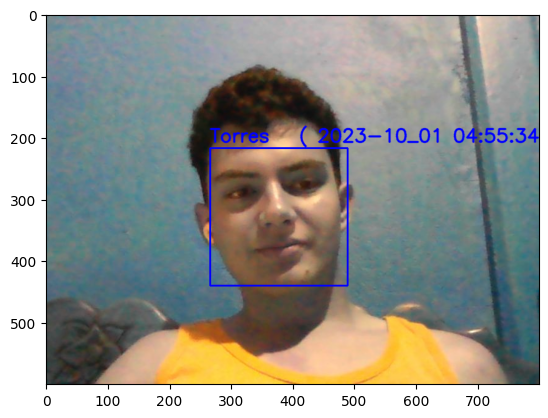

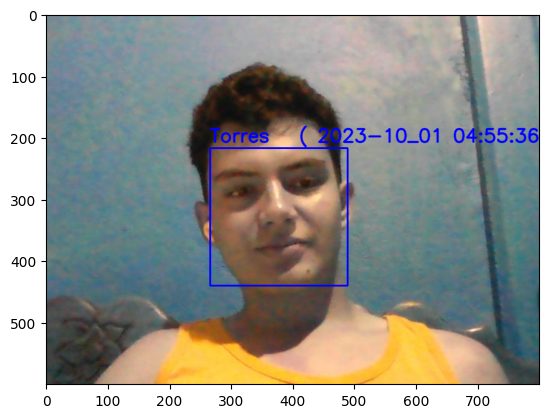

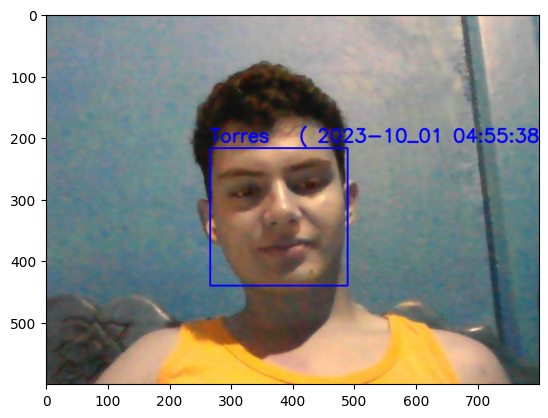

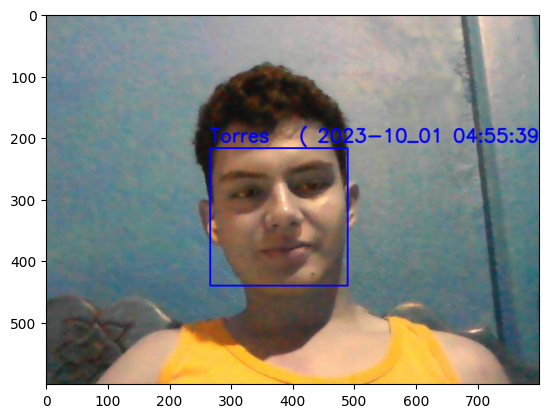

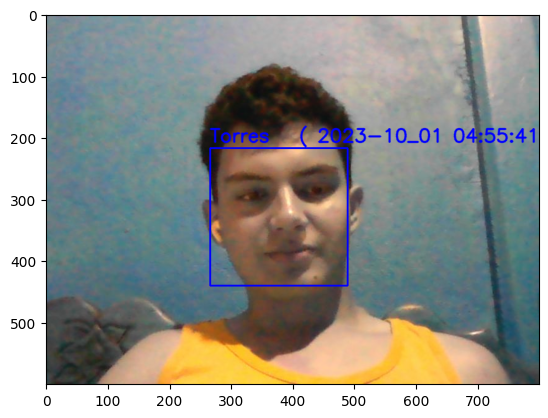

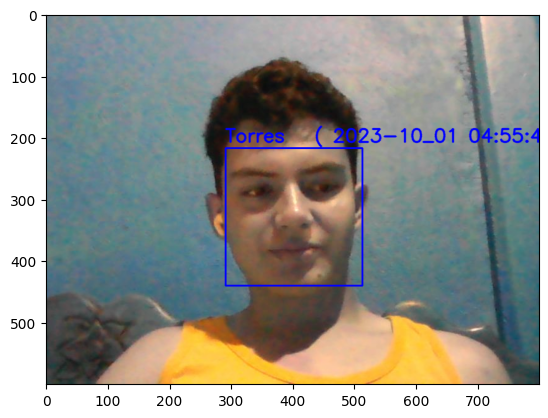

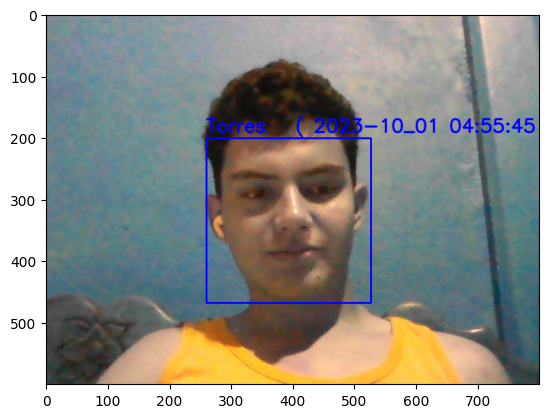

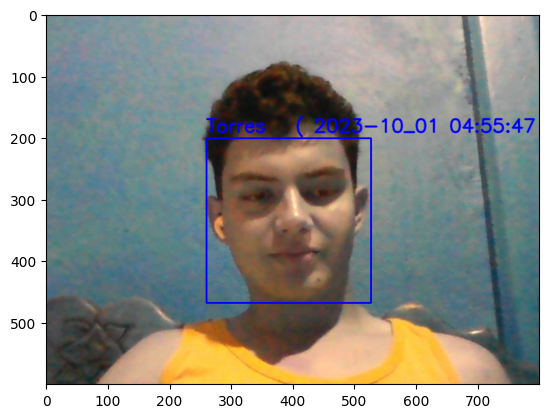

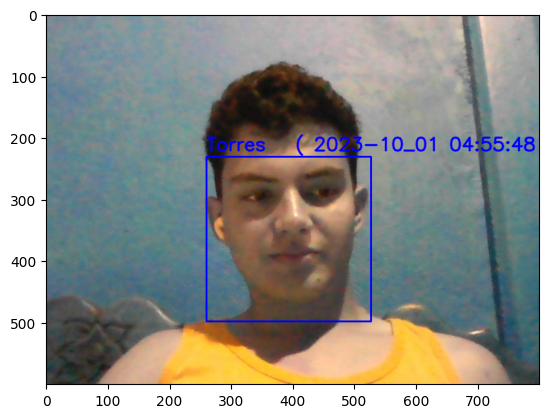

In [17]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
bbox = ''

while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # convert JS response to OpenCV Image
  frame = js_to_image(js_reply["img"])

  # Get the face locations from the frame
  face_locations = face_recognition.face_locations(frame)

  # For each face in the frame
  for (top, right, bottom, left) in face_locations:
      # Draw a rectangle around the face
      cv2.rectangle(
          frame,
          (left, top),
          (right, bottom),
          (0, 0, 255),
          2,
      )
      # Get the face encoding of the face
      face_encoding = face_recognition.face_encodings(frame, [(top, right, bottom, left)])[0]

      # Compare the face encoding to the faces in the database
      matches = face_recognition.compare_faces(list(registered_faces.values()), face_encoding)

      # If there is a match
      if True in matches:
          # Get the index of the match
          match_index = matches.index(True)

          # Get the name of the match
          match_name = list(registered_faces.keys())[match_index]

          curret_time = datetime.now().strftime(" %Y-%m_%d %H:%M:%S ")

          display_text = f"{ match_name }   ({ curret_time }) "

          # Draw the name of the match on the frame
          cv2.putText(
              frame,
              display_text,
              (left, top - 10),
              cv2.FONT_HERSHEY_SIMPLEX,
              1,
              (0, 0, 255),
              2,
              cv2.LINE_AA,
          )
      else:
          # Draw unknown on the frame
          cv2.putText(
              frame,
              "Unknown",
              (left, top - 10),
              cv2.FONT_HERSHEY_SIMPLEX,
              1,
              (0, 0, 255),
              2,
              cv2.LINE_AA,
          )

  # Show image
  plt.imshow(frame)
  plt.show()